# CLAHE (Contrast Limited Adaptive Histogram Equalization) Pipeline for Intrinsic Decomposition

This notebook mirrors the processing flow of `main.ipynb` and the earlier histogram equalization study, but applies **CLAHE** to improve local contrast before running the intrinsic (ordinal shading) pipeline. We process:

- All ARAP dataset input images (producing CLAHE-adjusted versions).
- The first 1000 IIW dataset images (numeric order) as a controlled subset.

After preprocessing we run the ordinal shading models and evaluate:

- ARAP: LMSE, RMSE, SSIM versus ground-truth albedo and shading.
- IIW: WHDR over reflectance predictions.

Directory naming convention here uses `clahe_input` / `clahe_output` (replacing prior `histo_equal_*`).

> If OpenCV (`cv2`) is available we use its CLAHE on the Y (luminance) channel in YCrCb space. Otherwise we fall back to `skimage.exposure.equalize_adapthist` applied to the V channel in HSV.

Sections:
1. Environment Setup
2. Paths & Directory Creation
3. CLAHE Utilities
4. ARAP CLAHE Preprocessing
5. IIW CLAHE Preprocessing (First 1000)
6. Load Models
7. ARAP Inference (CLAHE Inputs)
8. IIW Inference (CLAHE Subset)
9. ARAP Metrics (LMSE/RMSE/SSIM)
10. IIW WHDR Evaluation
11. Visual Comparisons
12. Integrity Checks

In [1]:
# 1. Environment Setup
import sys, os
sys.path.insert(0, 'imports')
print('✅ Environment ready (requirements + intrinsic package).')

✅ Environment ready (requirements + intrinsic package).


In [2]:
# 2. Define Paths & Create Directories
import os
from pathlib import Path
ARAP_INPUT = r'E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Input_Images'
ARAP_CLAHE_INPUT = r'E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\clahe_input'
ARAP_CLAHE_OUTPUT = r'E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\clahe_output'
ARAP_CLAHE_OUTPUT_ALB = os.path.join(ARAP_CLAHE_OUTPUT, 'albedo')
ARAP_CLAHE_OUTPUT_SHD = os.path.join(ARAP_CLAHE_OUTPUT, 'shading')
IIW_INPUT = r'E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\images'
IIW_CLAHE_INPUT = r'E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\clahe_images'
IIW_CLAHE_OUTPUT = r'E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\clahe_output'
IIW_ANNOTATIONS = r'E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\annotations'
for d in [ARAP_CLAHE_INPUT, ARAP_CLAHE_OUTPUT_ALB, ARAP_CLAHE_OUTPUT_SHD, IIW_CLAHE_INPUT, IIW_CLAHE_OUTPUT]:
    os.makedirs(d, exist_ok=True)
print('✅ Created/verified CLAHE directories.')

✅ Created/verified CLAHE directories.


In [3]:
# 3. CLAHE Utilities
import numpy as np
from PIL import Image
try:
    import cv2
    _HAS_CV2 = True
except ImportError:
    _HAS_CV2 = False
from skimage import exposure

def to_uint8(arr: np.ndarray) -> np.ndarray:
    arr = np.clip(arr, 0, 1)
    return (arr * 255).astype(np.uint8)

def clahe_luminance_rgb(img: np.ndarray, clip_limit=2.0, tile_grid_size=(8,8)) -> np.ndarray:
    """Apply CLAHE to luminance channel; returns float RGB in [0,1]."""
    if img.dtype != np.uint8:
        img8 = to_uint8(img)
    else:
        img8 = img
    if _HAS_CV2:
        ycrcb = cv2.cvtColor(img8, cv2.COLOR_RGB2YCrCb)
        Y, Cr, Cb = cv2.split(ycrcb)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        Y_eq = clahe.apply(Y)
        out = cv2.cvtColor(cv2.merge([Y_eq, Cr, Cb]), cv2.COLOR_YCrCb2RGB)
    else:
        pil_img = Image.fromarray(img8)
        h, s, v = pil_img.convert('HSV').split()
        v_arr = np.asarray(v).astype(np.float32) / 255.0
        v_eq = exposure.equalize_adapthist(v_arr, clip_limit=0.01)
        v_u8 = to_uint8(v_eq)
        out = np.asarray(Image.merge('HSV', (h, s, Image.fromarray(v_u8))).convert('RGB'))
    return out.astype(np.float32)/255.0

def batch_clahe(src_dir: str, dst_dir: str, limit: int | None = None, force=False, clip_limit=2.0, tile_grid_size=(8,8)):
    import os
    from tqdm import tqdm
    exts = ('.png','.jpg','.jpeg','.PNG','.JPG','.JPEG')
    files = [f for f in os.listdir(src_dir) if f.endswith(exts)]
    files.sort()
    if limit: files = files[:limit]
    new_count = 0
    for f in tqdm(files, desc=f'CLAHE ({os.path.basename(src_dir)})'):
        ip = os.path.join(src_dir, f)
        op = os.path.join(dst_dir, f)
        if (not force) and os.path.exists(op):
            continue
        try:
            arr = np.asarray(Image.open(ip).convert('RGB')).astype(np.float32)/255.0
            eq = clahe_luminance_rgb(arr, clip_limit=clip_limit, tile_grid_size=tile_grid_size)
            Image.fromarray(to_uint8(eq)).save(op)
            new_count += 1
        except Exception as e:
            print(f'Skip {f}: {e}')
    print(f'✅ CLAHE done for {src_dir} → {dst_dir}. Wrote {new_count} new files (total now {len(os.listdir(dst_dir))}).')

In [4]:
# 4. ARAP: Generate CLAHE Inputs
batch_clahe(ARAP_INPUT, ARAP_CLAHE_INPUT, limit=None, force=False)
import os
orig_arap = len([f for f in os.listdir(ARAP_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))])
clahe_arap = len([f for f in os.listdir(ARAP_CLAHE_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))])
print(f'Original ARAP: {orig_arap} | CLAHE files present: {clahe_arap}')

CLAHE (Input_Images): 100%|██████████| 21/21 [00:03<00:00,  6.27it/s]


✅ CLAHE done for E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Input_Images → E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\clahe_input. Wrote 21 new files (total now 21).
Original ARAP: 21 | CLAHE files present: 21


In [4]:
# 5. IIW: Generate CLAHE Inputs (First 1000 Images)
import re, os

def numeric_sort_key(fname: str):
    stem = os.path.splitext(fname)[0]
    m = re.match(r'^(\d+)', stem)
    if m: return (int(m.group(1)), stem.lower())
    return (float('inf'), stem.lower())

all_iiw = [f for f in os.listdir(IIW_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))]
all_iiw.sort(key=numeric_sort_key)
subset = all_iiw[:1000]
print(f'Total IIW images: {len(all_iiw)} | Taking first 1000: {len(subset)}')
from tqdm import tqdm
new_written = 0
for f in tqdm(subset, desc='CLAHE IIW (first 1000)'):
    src = os.path.join(IIW_INPUT, f)
    dst = os.path.join(IIW_CLAHE_INPUT, f)
    if os.path.exists(dst):
        continue
    try:
        arr = np.asarray(Image.open(src).convert('RGB')).astype(np.float32)/255.0
        eq = clahe_luminance_rgb(arr)
        Image.fromarray(to_uint8(eq)).save(dst)
        new_written += 1
    except Exception as e:
        print(f'Skip {f}: {e}')
print(f'✅ IIW CLAHE complete. Newly written: {new_written} | Total present: {len(os.listdir(IIW_CLAHE_INPUT))}')

Total IIW images: 5230 | Taking first 1000: 1000


CLAHE IIW (first 1000): 100%|██████████| 1000/1000 [01:10<00:00, 14.12it/s]

Total IIW images: 5230 | Taking first 1000: 1000


CLAHE IIW (first 1000): 100%|██████████| 1000/1000 [01:10<00:00, 14.12it/s]

✅ IIW CLAHE complete. Newly written: 1000 | Total present: 1000


In [4]:
# 5B. Synthetic Dense: Generate Histogram-Equalized Inputs
import os
from pathlib import Path

# Configure Synthetic Dense paths (raw Windows strings)
SYN_DENSE_INPUT = r"E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Base_input"
SYN_DENSE_EQ_INPUT = r"E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Clahe_input"

# Create destination directory
os.makedirs(SYN_DENSE_EQ_INPUT, exist_ok=True)

# Reuse batch_equalize utility defined earlier
batch_clahe(SYN_DENSE_INPUT, SYN_DENSE_EQ_INPUT, limit=None, force=False)

# Sanity check counts
orig_sd = len([f for f in os.listdir(SYN_DENSE_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))])
eq_sd = len([f for f in os.listdir(SYN_DENSE_EQ_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))])
print(f"Synthetic Dense original count: {orig_sd} | Equalized present: {eq_sd}")

CLAHE (Base_input): 100%|██████████| 23/23 [00:00<00:00, 9264.28it/s]

✅ CLAHE done for E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Base_input → E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Clahe_input. Wrote 0 new files (total now 23).
Synthetic Dense original count: 23 | Equalized present: 23


In [5]:
# 6. Load Models
import torch, os
from intrinsic.pipeline import run_pipeline
from altered_midas.midas_net import MidasNet
from altered_midas.midas_net_custom import MidasNet_small
from chrislib.general import view, invert
from chrislib.data_util import load_image

device = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_DIR = 'models'
ord_model = MidasNet(); ord_model.load_state_dict(torch.load(os.path.join(MODEL_DIR,'stage_0_v21.pt'), map_location=device)); ord_model.eval().to(device)
iid_model = MidasNet_small(exportable=False, input_channels=5, output_channels=1); iid_model.load_state_dict(torch.load(os.path.join(MODEL_DIR,'stage_1_v21.pt'), map_location=device)); iid_model.eval().to(device)
col_model = MidasNet(activation='sigmoid', input_channels=7, output_channels=2); col_model.load_state_dict(torch.load(os.path.join(MODEL_DIR,'stage_2_v21.pt'), map_location=device)); col_model.eval().to(device)
alb_model = MidasNet(activation='sigmoid', input_channels=9, output_channels=3, last_residual=True); alb_model.load_state_dict(torch.load(os.path.join(MODEL_DIR,'stage_3_v21.pt'), map_location=device)); alb_model.eval().to(device)
dif_model = MidasNet(activation='sigmoid', input_channels=9, output_channels=3); dif_model.load_state_dict(torch.load(os.path.join(MODEL_DIR,'stage_4_v21.pt'), map_location=device)); dif_model.eval().to(device)
models = {'ord_model': ord_model,'iid_model': iid_model,'col_model': col_model,'alb_model': alb_model,'dif_model': dif_model}
print(f'✅ Models loaded on {device}.')

Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main
Using cache found in C:\Users\Arnav Jalan/.cache\torch\hub\facebookresearch_WSL-Images_main


✅ Models loaded on cpu.


In [ ]:
# 7. ARAP Inference (CLAHE Inputs)
from tqdm import tqdm
from imageio import imwrite


arap_files = [f for f in os.listdir(ARAP_CLAHE_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))]
arap_files.sort()
print(f'CLAHE ARAP images: {len(arap_files)}')
for f in tqdm(arap_files, desc='ARAP CLAHE inference'):
    img = load_image(os.path.join(ARAP_CLAHE_INPUT, f))
    if img.ndim == 3 and img.shape[2] == 4:
        img = img[:,:,:3]
    res = run_pipeline(models, img, device=device)
    alb = view(res['hr_alb'])
    shd = 1 - invert(res['dif_shd'])
    stem = os.path.splitext(f)[0]
    imwrite(os.path.join(ARAP_CLAHE_OUTPUT_ALB, f'{stem}_alb.png'), (alb*255).astype(np.uint8))
    imwrite(os.path.join(ARAP_CLAHE_OUTPUT_SHD, f'{stem}_shd.png'), (shd*255).astype(np.uint8))
print('✅ ARAP CLAHE inference complete.')

CLAHE ARAP images: 21


ARAP CLAHE inference: 100%|██████████| 21/21 [07:35<00:00, 21.70s/it]

✅ ARAP CLAHE inference complete.


In [ ]:
# 8. IIW Inference (CLAHE Subset)
from imageio import imwrite
import re
from tqdm import tqdm

iiw_files = [f for f in os.listdir(IIW_CLAHE_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))]

def iiw_numeric_key(fname):
    stem = os.path.splitext(fname)[0]
    m = re.match(r'^(\d+)', stem)
    if m: return (int(m.group(1)), stem.lower())
    return (float('inf'), stem.lower())

iiw_files.sort(key=iiw_numeric_key)
print(f'CLAHE IIW subset images: {len(iiw_files)}')
for f in tqdm(iiw_files, desc='IIW CLAHE inference'):
    img = load_image(os.path.join(IIW_CLAHE_INPUT, f))
    if img.ndim == 3 and img.shape[2] == 4:
        img = img[:,:,:3]
    res = run_pipeline(models, img, device=device)
    alb = view(res['hr_alb'])
    stem = os.path.splitext(f)[0]
    imwrite(os.path.join(IIW_CLAHE_OUTPUT, f'{stem}_reflectance.png'), (alb*255).astype(np.uint8))
print('✅ IIW CLAHE inference complete.')

CLAHE IIW subset images: 1000


IIW CLAHE inference: 100%|██████████| 1000/1000 [3:17:14<00:00, 11.83s/it] 

✅ IIW CLAHE inference complete.


In [6]:
# 7B. Run Pipeline on Synthetic Dense Histogram-Equalized Inputs
from tqdm import tqdm
from imageio import imwrite
import os

# Inputs and outputs
SYN_DENSE_EQ_INPUT = globals().get('SYN_DENSE_EQ_INPUT', r"E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Clahe_input")
SYN_DENSE_EQ_OUTPUT = r"E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Clahe_output"
SYN_DENSE_EQ_OUTPUT_ALB = os.path.join(SYN_DENSE_EQ_OUTPUT, "albedo")
SYN_DENSE_EQ_OUTPUT_SHD = os.path.join(SYN_DENSE_EQ_OUTPUT, "shading")
os.makedirs(SYN_DENSE_EQ_OUTPUT_ALB, exist_ok=True)
os.makedirs(SYN_DENSE_EQ_OUTPUT_SHD, exist_ok=True)

syn_eq_images = [f for f in os.listdir(SYN_DENSE_EQ_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))]
syn_eq_images.sort()
print(f"Equalized Synthetic Dense images: {len(syn_eq_images)}")

for f in tqdm(syn_eq_images, desc="Synthetic Dense equalized inference"):
    img = load_image(os.path.join(SYN_DENSE_EQ_INPUT, f))
    if img.ndim == 3 and img.shape[2] == 4:
        img = img[:,:,:3]
    res = run_pipeline(models, img, device=device)
    alb = view(res["hr_alb"])  # gamma-corrected albedo
    shd = 1 - invert(res["dif_shd"])  # tonemapped diffuse shading
    stem = os.path.splitext(f)[0]
    imwrite(os.path.join(SYN_DENSE_EQ_OUTPUT_ALB, f"{stem}_alb.png"), (alb*255).astype(np.uint8))
    imwrite(os.path.join(SYN_DENSE_EQ_OUTPUT_SHD, f"{stem}_shd.png"), (shd*255).astype(np.uint8))
print("✅ Synthetic Dense equalized inference complete.")

Equalized Synthetic Dense images: 23


Synthetic Dense equalized inference:   0%|          | 0/23 [00:00<?, ?it/s]

Synthetic Dense equalized inference: 100%|██████████| 23/23 [03:17<00:00,  8.60s/it]

✅ Synthetic Dense equalized inference complete.


In [9]:
# 9. ARAP Metrics (LMSE, RMSE, SSIM)
import numpy as np, os
from imageio import imread
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize
GT_ALB_DIR = r'E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Gt_Albedo'
GT_SHD_DIR = r'E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Gt_Shading'
PRED_ALB_DIR = ARAP_CLAHE_OUTPUT_ALB
PRED_SHD_DIR = ARAP_CLAHE_OUTPUT_SHD

def to_gray_strict(arr):
    if arr.ndim==3 and arr.shape[2]==4: arr = arr[:,:,:3]
    if arr.ndim==3 and arr.shape[2]==3: arr = np.mean(arr, axis=2)
    return np.squeeze(arr)

def safe_ssim(a,b):
    h,w = b.shape
    win = min(7,h,w)
    if win < 3: win = 3
    if win % 2 == 0: win -= 1
    return ssim(a,b,data_range=1.0,win_size=win)

def compute_metrics(pred_dir, gt_dir, kind):
    lmse_vals, rmse_vals, ssim_vals = [], [], []
    for f in sorted(os.listdir(pred_dir)):
        fl = f.lower()
        if kind=='alb' and '_alb' not in fl: continue
        if kind=='shd' and '_shd' not in fl: continue
        stem = f.rsplit('_alb',1)[0] if kind=='alb' else f.rsplit('_shd',1)[0]
        gt_suffix = '_albedo' if kind=='alb' else '_shading'
        gt_file = None
        for ext in ['.png','.jpg','.jpeg']:
            cand = f'{stem}{gt_suffix}{ext}'
            if os.path.exists(os.path.join(gt_dir,cand)):
                gt_file = cand; break
        if not gt_file: continue
        pred = imread(os.path.join(pred_dir,f)).astype(np.float32)/255.0
        gt = imread(os.path.join(gt_dir,gt_file)).astype(np.float32)/255.0
        p = to_gray_strict(pred); g = to_gray_strict(gt)
        if p.shape != g.shape:
            p = resize(p, g.shape, order=1, preserve_range=True, anti_aliasing=True)
        def lmse(gm, pm, window_size=20, window_shift=10):
            H,W = gm.shape
            if H<window_size or W<window_size:
                return float(np.mean((gm-pm)**2))
            acc=[]
            for i in range(0,H-window_size+1,window_shift):
                for j in range(0,W-window_size+1,window_shift):
                    gp = gm[i:i+window_size,j:j+window_size]
                    pp = pm[i:i+window_size,j:j+window_size]
                    acc.append(np.mean((gp-pp)**2))
            return float(np.mean(acc)) if acc else float('nan')
        lmse_vals.append(lmse(g,p))
        rmse_vals.append(float(np.sqrt(np.mean((p-g)**2))))
        ssim_vals.append(float(safe_ssim(p,g)))
    return (float(np.nanmean(lmse_vals)), float(np.nanmean(rmse_vals)), float(np.nanmean(ssim_vals)))

lmse_a, rmse_a, ssim_a = compute_metrics(PRED_ALB_DIR, GT_ALB_DIR, 'alb')
lmse_s, rmse_s, ssim_s = compute_metrics(PRED_SHD_DIR, GT_SHD_DIR, 'shd')
print(f'CLAHE ARAP Albedo: LMSE={lmse_a:.4f}, RMSE={rmse_a:.4f}, SSIM={ssim_a:.4f}')
print(f'CLAHE ARAP Shading: LMSE={lmse_s:.4f}, RMSE={rmse_s:.4f}, SSIM={ssim_s:.4f}')

C:\Users\Arnav Jalan\AppData\Local\Temp\ipykernel_9716\1523076536.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred = imread(os.path.join(pred_dir,f)).astype(np.float32)/255.0
C:\Users\Arnav Jalan\AppData\Local\Temp\ipykernel_9716\1523076536.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt = imread(os.path.join(gt_dir,gt_file)).astype(np.float32)/255.0


CLAHE ARAP Albedo: LMSE=0.0751, RMSE=0.2398, SSIM=0.6595
CLAHE ARAP Shading: LMSE=0.0789, RMSE=0.2400, SSIM=0.6570


In [15]:
# 10. IIW WHDR Evaluation (Reflectance)
import json
from PIL import Image

def srgb_to_rgb(srgb):
    srgb = np.asarray(srgb, dtype=np.float32)
    out = np.zeros_like(srgb, dtype=np.float32)
    m = srgb <= 0.04045
    out[m] = srgb[m]/12.92
    out[~m] = ((srgb[~m]+0.055)/1.055)**2.4
    return out

def load_image_linear(path, is_srgb=True):
    im = np.asarray(Image.open(path)).astype(np.float32)/255.0
    return srgb_to_rgb(im) if is_srgb else im

def compute_whdr(reflectance, judgements, delta=0.10):
    pts = {p['id']: p for p in judgements['intrinsic_points']}
    comps = judgements['intrinsic_comparisons']
    H,W = reflectance.shape[:2]
    err_sum=0.0; w_sum=0.0
    for c in comps:
        darker=c.get('darker')
        if darker not in ('1','2','E'): continue
        w=c.get('darker_score');
        if not w or w<=0: continue
        p1=pts.get(c['point1']); p2=pts.get(c['point2'])
        if p1 is None or p2 is None: continue
        if not p1.get('opaque',False) or not p2.get('opaque',False): continue
        y1=min(H-1,max(0,int(p1['y']*H))); x1=min(W-1,max(0,int(p1['x']*W)))
        y2=min(H-1,max(0,int(p2['y']*H))); x2=min(W-1,max(0,int(p2['x']*W)))
        l1=max(1e-10,float(np.mean(reflectance[y1,x1,...])))
        l2=max(1e-10,float(np.mean(reflectance[y2,x2,...])))
        if l2/l1 > 1+delta: alg='1'
        elif l1/l2 > 1+delta: alg='2'
        else: alg='E'
        if alg != darker: err_sum += w
        w_sum += w
    return err_sum / w_sum if w_sum>0 else None

valid_exts = ('.png','.jpg','.jpeg')
refl_files = [f for f in os.listdir(IIW_CLAHE_OUTPUT) if f.lower().endswith(valid_exts) and f.endswith('_reflectance.png')]
refl_files.sort()
whdr_results = []
for f in refl_files:
    stem = os.path.splitext(f)[0]
    if not stem.endswith('_reflectance'): continue
    photo_id = stem.rsplit('_reflectance',1)[0]
    ann = os.path.join(IIW_ANNOTATIONS, f'{photo_id}.json')
    if not os.path.exists(ann): continue
    try:
        refl = load_image_linear(os.path.join(IIW_CLAHE_OUTPUT,f), is_srgb=True)
        with open(ann,'r') as jf: judg = json.load(jf)
        wh = compute_whdr(refl, judg)
        if wh is not None:
            whdr_results.append((photo_id, wh))
            print(f'{photo_id}: WHDR={wh:.4f}')
    except Exception as e:
        print(f'{photo_id}: error {e}')
if whdr_results:
    mean_whdr = float(np.mean([v for _,v in whdr_results]))
    print(f'\nCLAHE IIW Mean WHDR = {mean_whdr:.4f} over {len(whdr_results)} images')
else:
    print('No WHDR scores computed.')

10013: WHDR=0.2837
10066: WHDR=0.3166
10068: WHDR=0.2872
10070: WHDR=0.3168
10121: WHDR=0.5414
10068: WHDR=0.2872
10070: WHDR=0.3168
10121: WHDR=0.5414
10143: WHDR=0.2550
10148: WHDR=0.1127
10143: WHDR=0.2550
10148: WHDR=0.1127
1014: WHDR=0.6978
10152: WHDR=0.2064
1014: WHDR=0.6978
10152: WHDR=0.2064
10165: WHDR=0.4442
10174: WHDR=0.2737
10224: WHDR=0.1775
10165: WHDR=0.4442
10174: WHDR=0.2737
10224: WHDR=0.1775
10231: WHDR=0.1348
10272: WHDR=0.4472
10291: WHDR=0.6717
10231: WHDR=0.1348
10272: WHDR=0.4472
10291: WHDR=0.6717
10324: WHDR=0.0770
10331: WHDR=0.1011
10348: WHDR=0.3741
10324: WHDR=0.0770
10331: WHDR=0.1011
10348: WHDR=0.3741
10356: WHDR=0.4769
10361: WHDR=0.1726
10386: WHDR=0.2758
10356: WHDR=0.4769
10361: WHDR=0.1726
10386: WHDR=0.2758
10403: WHDR=0.6070
10436: WHDR=0.3419
10403: WHDR=0.6070
10436: WHDR=0.3419
10456: WHDR=0.2591
10457: WHDR=0.1915
10456: WHDR=0.2591
10457: WHDR=0.1915
10466: WHDR=0.3356
10469: WHDR=0.5976
10477: WHDR=0.5093
10466: WHDR=0.3356
10469: WHDR=0.

In [7]:
# Synthetic Dense Albedo Metrics Only (LMSE, RMSE, SSIM) with robust GT matching
import os
import numpy as np
from skimage.metrics import structural_similarity as ssim
from imageio import imread
from skimage.transform import resize

# Synthetic Dense paths (update if your dataset root differs)
sd_pred_albedo_dir = r"E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Clahe_output\albedo"
sd_gt_albedo_dir = r"E:\COLLEGE MATERIAL\Ordinal_Shading\Synthetic Dense Dataset(Sentinel)\Gt_albedo"

def to_gray_strict(arr):
    if arr.ndim == 3 and arr.shape[2] == 4:
        arr = arr[:, :, :3]
    if arr.ndim == 3 and arr.shape[2] == 3:
        arr = np.mean(arr, axis=2)
    return np.squeeze(arr)

def safe_ssim(a, b):
    h, w = b.shape
    win = min(7, h, w)
    if win < 3: win = 3
    if win % 2 == 0: win -= 1
    return ssim(a, b, data_range=1.0, win_size=win)

def find_gt_file(gt_dir: str, stem: str):
    candidates = []
    # Common direct patterns
    for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']:
        candidates.append(f"{stem}_albedo{ext}")
        candidates.append(f"{stem}{ext}")
    for c in candidates:
        p = os.path.join(gt_dir, c)
        if os.path.exists(p):
            return p
    # Fallback: scan directory for files that start with stem and contain 'alb' or 'albedo'
    low_stem = stem.lower()
    for f in os.listdir(gt_dir):
        fl = f.lower()
        if (fl.startswith(low_stem)) and (('albedo' in fl) or ('alb' in fl)) and fl.endswith(tuple(['.png','.jpg','.jpeg','.PNG','.JPG','.JPEG'])):
            return os.path.join(gt_dir, f)
    return None

def compute_albedo_metrics(pred_dir, gt_dir):
    lmse_vals, rmse_vals, ssim_vals = [], [], []
    pred_files = sorted([f for f in os.listdir(pred_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    if not pred_files:
        print(f"⚠ No predicted albedo files found in {pred_dir}")
        return None, None, None
    matched = 0; missing = 0
    for fname in pred_files:
        low = fname.lower()
        if not (low.endswith('_alb.png') or low.endswith('_alb.jpg') or low.endswith('_alb.jpeg')):
            continue
        stem = fname.rsplit('_alb', 1)[0]
        gt_path = find_gt_file(gt_dir, stem)
        if gt_path is None:
            missing += 1
            continue
        pred_path = os.path.join(pred_dir, fname)
        pred_img = imread(pred_path).astype(np.float32) / 255.0
        gt_img = imread(gt_path).astype(np.float32) / 255.0
        pred_gray = to_gray_strict(pred_img)
        gt_gray = to_gray_strict(gt_img)
        if pred_gray.shape != gt_gray.shape:
            pred_gray = resize(pred_gray, gt_gray.shape, order=1, preserve_range=True, anti_aliasing=True)
        def lmse(gt, pred, window_size=20, window_shift=10):
            h, w = gt.shape
            if h < window_size or w < window_size:
                return float(np.mean((gt - pred) ** 2))
            errors = []
            for i in range(0, h - window_size + 1, window_shift):
                for j in range(0, w - window_size + 1, window_shift):
                    gpatch = gt[i:i+window_size, j:j+window_size]
                    ppatch = pred[i:i+window_size, j:j+window_size]
                    errors.append(np.mean((gpatch - ppatch) ** 2))
            return float(np.mean(errors)) if errors else float('nan')
        lmse_vals.append(lmse(gt_gray, pred_gray))
        rmse_vals.append(float(np.sqrt(np.mean((pred_gray - gt_gray) ** 2))))
        ssim_vals.append(float(safe_ssim(pred_gray, gt_gray)))
        matched += 1
    if matched == 0:
        print(f"⚠ No GT matches found in {gt_dir} for stems of predictions in {pred_dir}. Check naming.")
        if missing > 0:
            print(f"   Missing GT for {missing} predicted files.")
        return None, None, None
    print(f"Matched {matched} pairs; Missing GT for {missing} files.")
    return float(np.nanmean(lmse_vals)), float(np.nanmean(rmse_vals)), float(np.nanmean(ssim_vals))

lmse_alb, rmse_alb, ssim_alb = compute_albedo_metrics(sd_pred_albedo_dir, sd_gt_albedo_dir)
if lmse_alb is None:
    print("Synthetic Dense Albedo: metrics unavailable (no matched pairs).")
else:
    print(f"Synthetic Dense Albedo: LMSE={lmse_alb:.4f}, RMSE={rmse_alb:.4f}, SSIM={ssim_alb:.4f}")

C:\Users\Arnav Jalan\AppData\Local\Temp\ipykernel_18004\2697091368.py:61: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pred_img = imread(pred_path).astype(np.float32) / 255.0
C:\Users\Arnav Jalan\AppData\Local\Temp\ipykernel_18004\2697091368.py:62: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt_img = imread(gt_path).astype(np.float32) / 255.0


Matched 22 pairs; Missing GT for 1 files.
Synthetic Dense Albedo: LMSE=0.0739, RMSE=0.2627, SSIM=0.5563


Selected ARAP samples: ['sponza', 'villa', 'whiteroom']


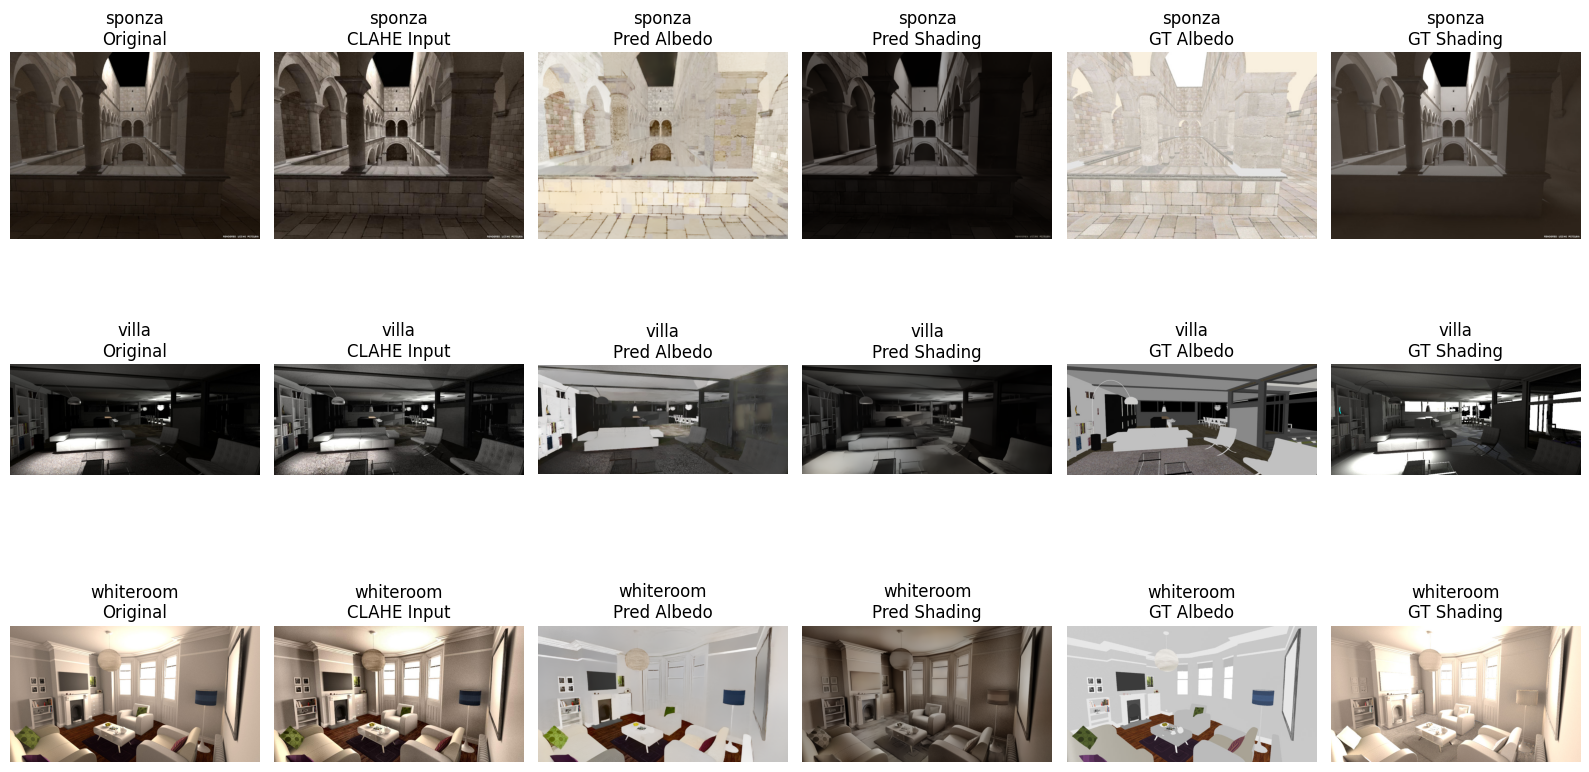

In [9]:
# 11. Qualitative Visualization: Original, CLAHE Input, Pred (Alb/Shd), GT (Alb/Shd) for 3 ARAP images
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Use existing globals (defined earlier), with safe fallbacks
ARAP_INPUT = globals().get('ARAP_INPUT', r'E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Input_Images')
ARAP_CLAHE_INPUT = globals().get('ARAP_CLAHE_INPUT', r'E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\clahe_input')
ARAP_CLAHE_OUTPUT_ALB = globals().get('ARAP_CLAHE_OUTPUT_ALB', r'E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\clahe_output\albedo')
ARAP_CLAHE_OUTPUT_SHD = globals().get('ARAP_CLAHE_OUTPUT_SHD', r'E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\clahe_output\shading')
GT_ALB_DIR = r'E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Gt_Albedo'
GT_SHD_DIR = r'E:\COLLEGE MATERIAL\Ordinal_Shading\ARAP Dataset\Gt_Shading'

valid_exts = ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']

def find_existing(base_dir, stem, suffix):
    """Find a file at base_dir matching stem + suffix + ext across common extensions."""
    for ext in valid_exts:
        p = os.path.join(base_dir, f"{stem}{suffix}{ext}")
        if os.path.exists(p):
            return p
    return None

def load_rgb(path):
    img = Image.open(path)
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    return np.asarray(img)

# Collect stems that have all 6 assets available
orig_files = [f for f in os.listdir(ARAP_INPUT) if f.lower().endswith(('.png','.jpg','.jpeg'))]
orig_files.sort()

candidates = []
for f in orig_files:
    stem = os.path.splitext(f)[0]
    eq_in_path = os.path.join(ARAP_CLAHE_INPUT, f)
    if not os.path.exists(eq_in_path):
        continue
    pred_alb_path = find_existing(ARAP_CLAHE_OUTPUT_ALB, stem, '_alb')
    pred_shd_path = find_existing(ARAP_CLAHE_OUTPUT_SHD, stem, '_shd')
    gt_alb_path = find_existing(GT_ALB_DIR, stem, '_albedo')
    gt_shd_path = find_existing(GT_SHD_DIR, stem, '_shading')
    if pred_alb_path and pred_shd_path and gt_alb_path and gt_shd_path:
        candidates.append((stem,
                           os.path.join(ARAP_INPUT, f),
                           eq_in_path,
                           pred_alb_path,
                           pred_shd_path,
                           gt_alb_path,
                           gt_shd_path))

if not candidates:
    raise RuntimeError('No ARAP samples found with Original, CLAHE input, Pred (alb/shd), and GT (alb/shd). Ensure preprocessing and inference ran successfully.')

# Choose last 3 valid samples
samples = candidates[-3:]
print('Selected ARAP samples:', [s[0] for s in samples])

# Plot grid: [Original, CLAHE Input, Pred Albedo, Pred Shading, GT Albedo, GT Shading]
rows = len(samples)
cols = 6
fig, axes = plt.subplots(rows, cols, figsize=(16, 3 * rows))
if rows == 1:
    axes = np.expand_dims(axes, 0)

for r, (stem, orig_p, clahe_p, pr_alb_p, pr_shd_p, gt_alb_p, gt_shd_p) in enumerate(samples):
    orig = load_rgb(orig_p)
    clahe_in = load_rgb(clahe_p)
    pr_alb = load_rgb(pr_alb_p)
    pr_shd = load_rgb(pr_shd_p)
    gt_alb = load_rgb(gt_alb_p)
    gt_shd = load_rgb(gt_shd_p)

    panels = [
        ('Original', orig),
        ('CLAHE Input', clahe_in),
        ('Pred Albedo', pr_alb),
        ('Pred Shading', pr_shd),
        ('GT Albedo', gt_alb),
        ('GT Shading', gt_shd),
    ]
    for c, (title, img) in enumerate(panels):
        ax = axes[r, c]
        ax.imshow(img)
        ax.set_title(f'{stem}\n{title}')
        ax.axis('off')

plt.tight_layout()
plt.show()

Selected IIW samples: ['180', '54', '63']


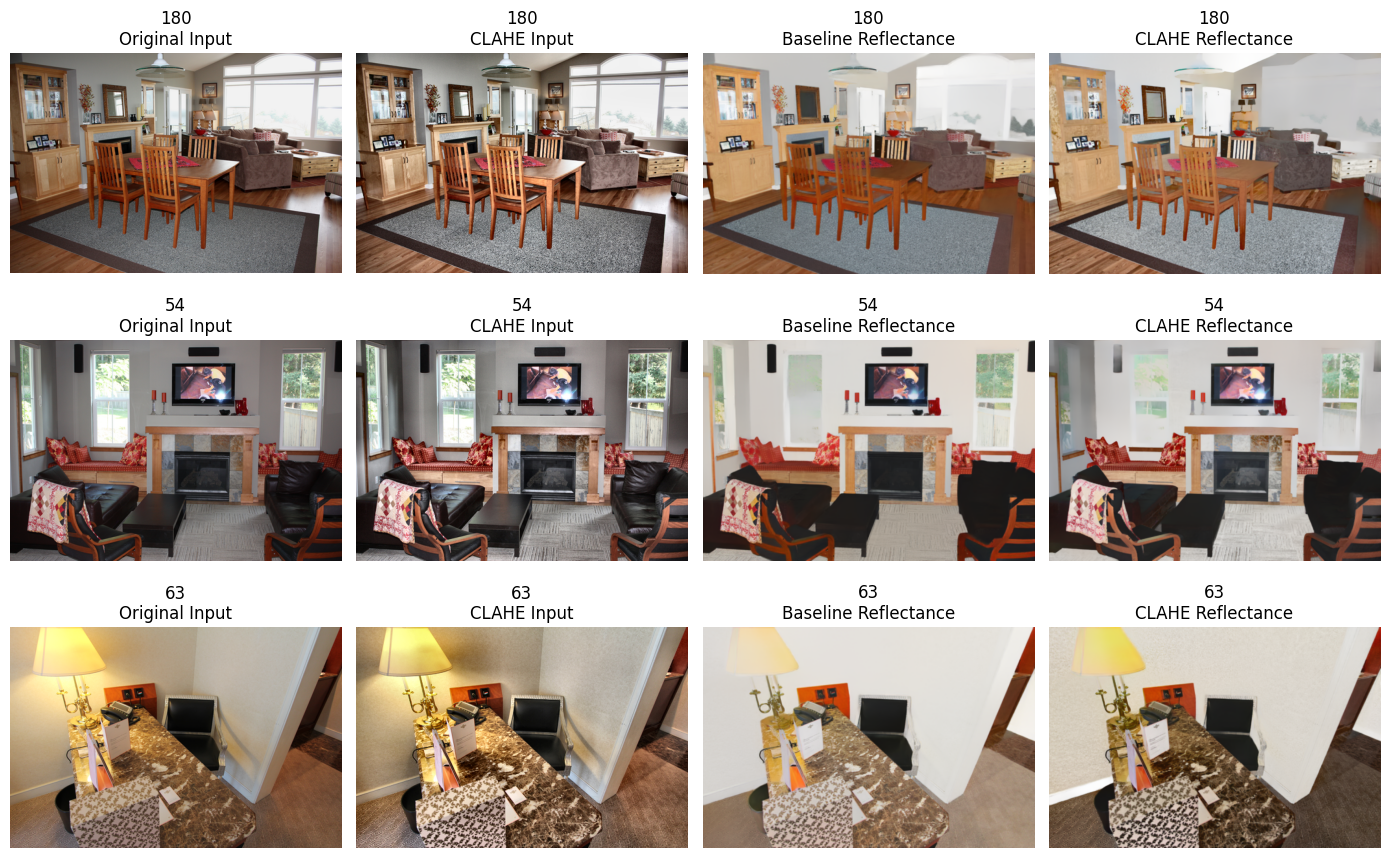

In [ ]:
# 11B. IIW Qualitative Visualization: Original, CLAHE Input, Baseline Reflectance, CLAHE Reflectance (last 3 samples)
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Use globals from earlier where available, define baseline output fallback
IIW_INPUT = globals().get('IIW_INPUT', r'E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\images')
IIW_CLAHE_INPUT = globals().get('IIW_CLAHE_INPUT', r'E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\clahe_images')
IIW_CLAHE_OUTPUT = globals().get('IIW_CLAHE_OUTPUT', r'E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\clahe_output')
IIW_BASE_OUTPUT = globals().get('IIW_OUTPUT', r'E:\COLLEGE MATERIAL\Ordinal_Shading\IIW Dataset\data\output')

valid_exts = ('.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG')

# Helpers

def load_rgb(path):
    img = Image.open(path)
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    return np.asarray(img)

# Build candidate list where all four assets exist
orig_files = [f for f in os.listdir(IIW_INPUT) if f.endswith(valid_exts)]
orig_files.sort()

candidates = []
for f in orig_files:
    stem = os.path.splitext(f)[0]
    orig_p = os.path.join(IIW_INPUT, f)
    clahe_in_p = os.path.join(IIW_CLAHE_INPUT, f)
    base_refl_p = os.path.join(IIW_BASE_OUTPUT, f'{stem}_reflectance.png')
    clahe_refl_p = os.path.join(IIW_CLAHE_OUTPUT, f'{stem}_reflectance.png')
    if all(os.path.exists(p) for p in [orig_p, clahe_in_p, base_refl_p, clahe_refl_p]):
        candidates.append((stem, orig_p, clahe_in_p, base_refl_p, clahe_refl_p))

if not candidates:
    raise RuntimeError('No IIW samples found with Original, CLAHE input, Baseline reflectance, and CLAHE reflectance. Ensure baseline and CLAHE inference were run.')

# Choose last 3 valid samples
samples = candidates[-3:]
print('Selected IIW samples:', [s[0] for s in samples])

# Plot grid: [Original, CLAHE Input, Baseline Reflectance, CLAHE Reflectance]
rows = len(samples)
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(14, 3 * rows))
if rows == 1:
    axes = np.expand_dims(axes, 0)

for r, (stem, orig_p, clahe_in_p, base_refl_p, clahe_refl_p) in enumerate(samples):
    orig = load_rgb(orig_p)
    clahe_in = load_rgb(clahe_in_p)
    base_refl = load_rgb(base_refl_p)
    clahe_refl = load_rgb(clahe_refl_p)

    panels = [
        ('Original Input', orig),
        ('CLAHE Input', clahe_in),
        ('Baseline Reflectance', base_refl),
        ('CLAHE Reflectance', clahe_refl),
    ]
    for c, (title, img) in enumerate(panels):
        ax = axes[r, c]
        ax.imshow(img)
        ax.set_title(f'{stem}\n{title}')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 12. Integrity Checks
issues = []
alb_ct = len([f for f in os.listdir(ARAP_CLAHE_OUTPUT_ALB) if f.lower().endswith('.png')])
shd_ct = len([f for f in os.listdir(ARAP_CLAHE_OUTPUT_SHD) if f.lower().endswith('.png')])
print(f'ARAP CLAHE Albedo files: {alb_ct} | Shading files: {shd_ct}')
iiw_refl_ct = len([f for f in os.listdir(IIW_CLAHE_OUTPUT) if f.endswith('_reflectance.png')])
print(f'IIW CLAHE Reflectance files: {iiw_refl_ct}')
if alb_ct == 0 or shd_ct == 0: issues.append('Missing ARAP CLAHE outputs.')
if iiw_refl_ct == 0: issues.append('Missing IIW CLAHE reflectance outputs.')
if 'lmse_a' not in globals(): issues.append('Metric variables not found (lmse_a).')
if issues:
    print('\n⚠ Issues:')
    for it in issues: print(' -', it)
else:
    print('\n✅ Integrity checks passed.')